# Assignment 1: ODrive setup and initial kinematics exploration

In homework 1 we will learn the basic functionality of the ODrive motor controller and the kinematics of the 5-bar leg. There are 5 problems below. You will turn this assignment in by uploading it to your own github repository for this assignment and then sending a link to ngravish@eng.ucsd.edu with the subject MAE_207_HW1. The assignment is to be completed in pairs, one per team.

If you would like, you directly ```fork``` this repository into your github account, this is found in the upper right hand corner. You can then download the repository to your computer using the ```clone``` button on the right side. Once you are done with the assignment, commit the changes back to the github online repository. 

Alternatively you can just download the .ipynb file, edit it as you solve the problems, and then in the end upload to a github repo.

Team #:

Names: Bowen Zhang/Seth Dike



## Problem 1: Familiarization with ODrive firmware

__1.1__ You should follow the instructions to flash the motor controller firmware found [here](https://github.com/madcowswe/ODrive).

__1.2__ In the ```Odrive/Firmware/MotorControl``` folder are the code files that control the motor. The most important file is ```low_level.c```. Find this file and familiarize yourself with it. 

__1.3__ In ```low_level.c``` the main function for motor control is ```control_motor_loop(Motor_t* motor)```. Find this function and copy and paste blocks of it into the cell below.  Annotate the function step-by-step in simple language the operations it performs. (*I have started this annotation*). Use the three backticks \`\`\` and the letter c for the c language to highlight each code block.






```c
void control_motor_loop(Motor_t* motor) {
    while (*(motor->axis_legacy.enable_control)) {
        if (osSignalWait(M_SIGNAL_PH_CURRENT_MEAS, PH_CURRENT_MEAS_TIMEOUT).status != osEventSignal) {
            motor->error = ERROR_FOC_MEASUREMENT_TIMEOUT;
            break;
        }

        if (!do_checks(motor))
            break;
        if (!loop_updates(motor))
            break;
```

The above code initiates a loop that will continue as long as the enable_control flag is true. The first three if statements check for errors in the motor current measurement, and check if there are errors in the motor operation.

```c

        // Only runs if anticogging.calib_anticogging is true; non-blocking
        anti_cogging_calibration(motor);

        // Position control
        // TODO Decide if we want to use encoder or pll position here
        float vel_des = motor->vel_setpoint;
        if (motor->control_mode >= CTRL_MODE_POSITION_CONTROL) {
            if (motor->rotor_mode == ROTOR_MODE_SENSORLESS) {
                motor->error = ERROR_POS_CTRL_DURING_SENSORLESS;
                break;
            }
            float pos_err = motor->pos_setpoint - motor->encoder.pll_pos;
            vel_des += motor->pos_gain * pos_err;
        }
```

The above code includes the anti-cogging function to map out the holding torque required at any position of the motor’s shaft; it runs only once it has been calibrated. The position control section either uses the pll (phase-locked loop) or the encoder's state.  This is the PID.  If our controls match our position as dictated by sensors, the loop breaks.  The last few lines involve the subtraction of the encoder's position from the commanded actions of the motor. This is the attempt to fix the position.

```c
        // Velocity limiting
        float vel_lim = motor->vel_limit;
        if (vel_des > vel_lim) vel_des = vel_lim;
        if (vel_des < -vel_lim) vel_des = -vel_lim;

        // Velocity control
        float Iq = motor->current_setpoint;
```

The above code is for velocity control and pushing this information to the motor.  Vel_lim corresponds to the maximum speed obtainable.  We constrain values above and below to be in our controllable range.

```c

        // Anti-cogging is enabled after calibration
        // We get the current position and apply a current feed-forward
        // ensuring that we handle negative encoder positions properly (-1 == motor->encoder.encoder_cpr - 1)
        if (motor->anticogging.use_anticogging) {
            Iq += motor->anticogging.cogging_map[mod(motor->encoder.pll_pos, motor->encoder.encoder_cpr)];
        }

        float v_err = vel_des - get_pll_vel(motor);
        if (motor->control_mode >= CTRL_MODE_VELOCITY_CONTROL) {
            Iq += motor->vel_gain * v_err;
        }
        //Velocity integral action before limiting
        Iq += motor->vel_integrator_current;
```

Now that the position and velocity has been calibrated, the anti-cogging can help establish a more uniform torque. The feed forward control mentioned attempts to estimate the disturbance of the input and cut past it.  The code calls the anticogging function and applies it to the positions of the motor and encoder.  Then, the velocity is compared (PID) and checked as to where it is based off of the desired parameter vel_des.

```c
        
        // Apply motor direction correction
        if (motor->rotor_mode == ROTOR_MODE_ENCODER ||
            motor->rotor_mode == ROTOR_MODE_RUN_ENCODER_TEST_SENSORLESS) {
            Iq *= motor->encoder.motor_dir;
        }
```

If the motor's mode and the encoder's mode are equivalent or the motor's parameters match the estimates of the encoder, update the direction of the motor.

```c
        // Current limiting
        float Ilim = MACRO_MIN(motor->current_control.current_lim, motor->current_control.max_allowed_current);
        bool limited = false;
        if (Iq > Ilim) {
            limited = true;
            Iq = Ilim;
        }
        if (Iq < -Ilim) {
            limited = true;
            Iq = -Ilim;
        }
```

This constrains the current in between the max controllable settings as mapped to the motor speed. i.e. if it's larger, it's set as the max, if it's lower, it's a min.

```c
        // Velocity integrator (behaviour dependent on limiting)
        if (motor->control_mode < CTRL_MODE_VELOCITY_CONTROL) {
            // reset integral if not in use
            motor->vel_integrator_current = 0.0f;
        } else {
            if (limited) {
                // TODO make decayfactor configurable
                motor->vel_integrator_current *= 0.99f;
            } else {
                motor->vel_integrator_current += (motor->vel_integrator_gain * current_meas_period) * v_err;
            }
        }
```

If the motor is under the velocity dictated by the controls, reset the integral (position).  If the velocity were to be above the mapped range, the current is set so that it is just under.  The last line is the PID/feedback correction for the current.

```c
        // Execute current command
        if (motor->motor_type == MOTOR_TYPE_HIGH_CURRENT) {
            if(!FOC_current(motor, 0.0f, Iq)){
                break; // in case of error exit loop, motor->error has been set by FOC_current
            }
        } else if (motor->motor_type == MOTOR_TYPE_GIMBAL) {
            //In gimbal motor mode, current is reinterptreted as voltage.
            if(!FOC_voltage(motor, 0.0f, Iq)){
                break; // in case of error exit loop, motor->error has been set by FOC_voltage
            }
        } else {
            motor->error = ERROR_NOT_IMPLEMENTED_MOTOR_TYPE;
            break;
        }

        ++(motor->loop_counter);
    }

    //We are exiting control, reset Ibus, and update brake current
    motor->current_control.Ibus = 0.0f;
    update_brake_current();
}
```

This block finishes the master loop for control of the motor.  The following are errors that can be outputted.  This section depends on the mode chosen for the motor-either gimbal or high current options.  If there is an error due to set currents, exit loop.  Then we have our loop counter and update the current controls and brake functions. 


## Problem 2: Connecting to ODrive through the python library

__2.1__ The ODrive provides a python library called ```odrive``` in the ```/ODrive/Tools/``` directory. A python library consists of a folder (```odrive``` in this case) which contains python files and a file called ```__init__.py```. Find this library.

__2.2__ Test that you can import the ```odrive``` library and other required libraries into Python by running the code below (shift-enter when the cell is selected). You may need to move your Copy the ```odrive``` folder to the same folder as this notebook, or move this notebook to the same directory as ```odrive```. 



In [1]:
import odrive.core
import time
import math

import numpy as np
import matplotlib.pyplot as plt

from IPython.lib.display import YouTubeVideo # for youtube videos


# This may be qt4 depending on your python environment
%matplotlib qt5


__2.3__ Run the code below to connect to the odrive motor controller. If this executes successfully you will be able to access the motor controller functions through the ```my_drive``` variable.

In [2]:
my_drive = odrive.core.find_any(consider_usb=True, consider_serial=False, printer=print)

# define handles to the motor functions
m0=my_drive.motor0
m1=my_drive.motor1 


looking for ODrive...
Found ODrive via PyUSB
ConfigurationValue 1
	InterfaceNumber 0,0
		EndpointAddress 130
	InterfaceNumber 1,1
		EndpointAddress 1
		EndpointAddress 129

EndpointAddress for writing 1

EndpointAddress for reading 129

Connecting to device on USB device bus 0 device 14
JSON: [{"name":"","id":0,"type":"json","access":"rw"},{"name":"vbus_voltage","id":1,"type":"float","access":"r"},{"name":"serial_number","id":2,"type":"uint64","access":"r"},{"name":"run_anticogging_calibration","id":3,"type":"function","arguments":[]},{"name":"config","id":5,"type":"object","members":[{"name":"brake_resistance","id":6,"type":"float","access":"rw"}]},{"name":"axis0","id":8,"type":"object","members":[{"name":"config","id":9,"type":"object","members":[{"name":"enable_control_at_start","id":10,"type":"bool","access":"rw"},{"name":"do_calibration_at_start","id":11,"type":"bool","access":"rw"}]}]},{"name":"motor0","id":14,"type":"object","members":[{"name":"config","id":15,"type":"object","m

## Problem 3: Exploring and interacting with the ODrive

__3.1__ Write a function to call read the encoder position and velocity estimates and return them. As a start, the encoder position for motor 0 can be read using the ```m0.encoder.pll_pos,m1.encoder.pll_pos``` command. 

In [3]:
# in python we can define a function using the def command. The function definition code is indicated by tab indented code. When the 
# tab indentation stops the function definition has stopped. As shown below we can define a function and then call it immediately after
def get_encoder_state():
  
    #
    # Your code here
    #
    motor0_position=m0.encoder.pll_pos
    motor0_velocity=m0.encoder.pll_vel
    motor1_position=m1.encoder.pll_pos
    motor1_velocity=m1.encoder.pll_vel
    return (motor0_position, motor0_velocity, motor1_position, motor1_velocity)
    
    
# We can now call this function in the same code block
state = get_encoder_state()
print(state)
print(state[0])

(-0.2623138725757599, -121.32391357421875, -0.7812493443489075, -121.35845947265625)
-0.2623138725757599


__3.2__ The motor encoder returns absolute position measurements that are zerod on the position the motor was in during startup. It is useful to define new motor origins for the left and righ motor. Extend the legs so that they are straight and then read the encoder positions to the tuple variable 

```home_position = (motor0_home, motor1_home)```

A tuple is like an array, it can contain sequences of objects (numbers, strings, etc.), but it cannot be changed after it is written so it is perfect for storing unchangeable data like the home location.

In [53]:
#
#  Your code here
#
m0.config.pos_gain =30
m1.config.pos_gain =30
m0.pos_setpoint=0
m1.pos_setpoint=0
home_position =(m0.encoder.pll_pos, m1.encoder.pll_pos)#your code here
print(home_position)


(0.2542817294597626, 0.7581309676170349)


__3.3__ The motor move commands will move them to absolute positions with respect to the encoder zero position, this may not be the same as the ```home_position``` that we defined above. Write a function to move the motors to an absolute position relative to the ```home_position```. For reference we can move a motor with the ```set_pos_setpoint(pos_setpoint, vel_feed_forward, current_feed_forward)``` command. We don't need the feedforward terms in this problem.

In [51]:
def move_motors(motor1_new_position, motor2_new_position, home):
    #
    # Your code here
    #
    m0.set_pos_setpoint(motor1_new_position-home[0],0,0)
    m1.set_pos_setpoint(motor2_new_position-home[1],0,0)
# we can call the function here 


move_motors(100, 100, home_position) # note make the intial move distance small!!



## Problem 4: Determine the workspace of the robot leg

__4.1__ The end of the robot leg has a hole in it. Place a pen in the hole, place a paper below the robot and trace out the boundary of the robot leg's workspace by hand. Make sure to note where the edge of the aluminum frame is. Take a picture of the workspace tracing (keep your robot in place) and attach it to you this notebook. You can attach images by putting them in the same directory and then writing ```![Image description](filename.extension)```  
[Image description](pic1.jpg)

__4.2__ Now repeat the measurement of the leg workspace while recording the encoder position (*relative to your new home*) in a loop. This is a measurement configuration space of the robot which is two dimensional ($\theta_0$, $\theta_1$), and bounded by the leg range of motion. Make a plot of the configuration space boundaries by plotting your measured positions as ```xy``` coordinates ($\theta_0$, $\theta_1$). Include two plots below, the first is the configuration space using encoder units, the second is scaled to $-\pi,\pi$. You will have to determined the calibration constant (note the encoder generates 2048\*4 counts per revolution).

In [54]:
m0.config.pos_gain =0
m1.config.pos_gain =0

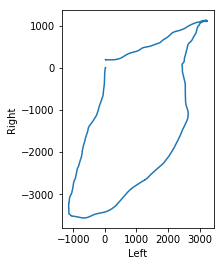

Text(0,0.5,'Right')

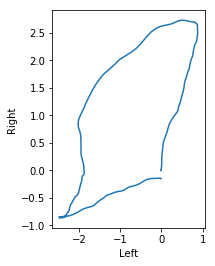

In [56]:
# Setup an array to store the encoder positions
left_motor = [] # initialize a empty list. You can add to a list with the left_motor.append(item) command
right_motor = [] # initialize an empty list
calibration=-4096/math.pi

    #different amplitude and phase combinations of your leg gait.    
t1=time.monotonic()
t3=0
while t3<15:
    t2=time.monotonic()
    t3=t2-t1
    #state
    #left_motor.append(state[0])
    #right_motor.append(state[2])
    left_motor.append(m0.encoder.pll_pos)
    right_motor.append(m1.encoder.pll_pos)

plt.subplot(1,2,1)
plt.plot(left_motor, right_motor)
plt.xlabel('Left')
plt.ylabel('Right')
plt.show()
plt.subplot(1,2,2)
plt.plot(np.divide(left_motor,calibration), np.divide(right_motor,calibration))
plt.xlabel('Left')
plt.ylabel('Right')

## Problem 5: Command a simple cyclic gait of the leg

__5.1__ In this last problem we will command a simple cyclic gait of the leg by sending sinusoidal position commands to the motors and exploring how phase and amplitude differences influence the foot motion. Record the encoder position while running the gait and provide plots of the motor angles as a function of time. Additionally, take a video of each gait and post it to youtube, including a link in the notebook at the very bottom. You can include youtube videos by entering the command ```YouTubeVideo('video_code')``` in a code cell, where video code is found from the youtube page.

*Provide plots and videos for three different gaits*


In [40]:
Amplitude_left =-700 
Amplitude_right =800 
Phase_left = 2*math.pi/3
Phase_right = -math.pi
m0.config.pos_gain =30    #Not sure for the value of the gain in the problem 
m1.config.pos_gain =30
initial_time = time.monotonic()  # record the current time
current_time = time.monotonic() 
left_motor=[]
right_motor = []
t=[]
while (current_time - initial_time) < 15:
    #
    #   Your code -- send position command
    current_time = time.monotonic()
    L_motor_pos=Amplitude_left*math.sin(current_time - initial_time-Phase_left)
    R_motor_pos=Amplitude_right*math.sin(current_time - initial_time-Phase_right)
    move_motors(L_motor_pos, R_motor_pos, home_position)
    
    #   Your code -- read encoder variables and save them to a list 
    left_motor.append(m0.encoder.pll_pos)
    right_motor.append(m1.encoder.pll_pos)
    t.append(current_time - initial_time)
    time.sleep(0.01)



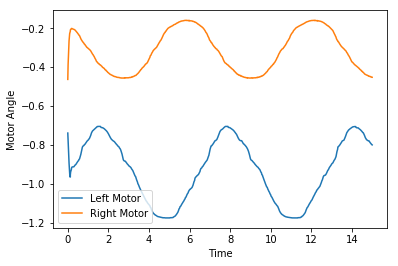

In [30]:
#  Plot for gait 1
#Amplitude_left =-300 
#Amplitude_right =200 
#Phase_left = 0
#Phase_right = math.pi/3
calibration=-4096/math.pi
plt.plot(t, np.divide(left_motor,calibration),t, np.divide(right_motor,calibration))
#RM=plt.plot(t, np.divide(right_motor,calibration))
plt.xlabel('Time')
plt.ylabel('Motor Angle')
plt.gca().legend(('Left Motor','Right Motor'))

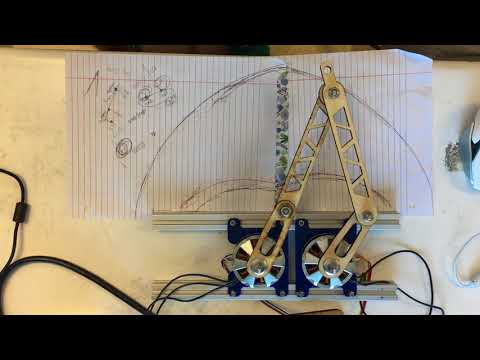

In [41]:
#
#  Youtube video for gait 1
#
YouTubeVideo('ZsLp9O94ZXY')

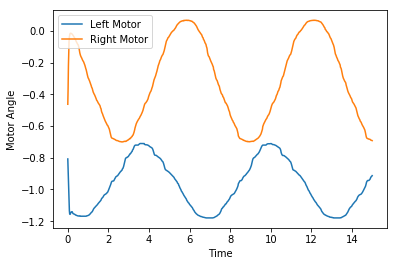

In [33]:
#
#  Plot for gait 2
#
#Amplitude_left =-300 
#Amplitude_right =500 
#Phase_left = 2*math.pi/3
#Phase_right = math.pi/3
calibration=-4096/math.pi
plt.plot(t, np.divide(left_motor,calibration),t, np.divide(right_motor,calibration))
#RM=plt.plot(t, np.divide(right_motor,calibration))
plt.xlabel('Time')
plt.ylabel('Motor Angle')
plt.gca().legend(('Left Motor','Right Motor'))

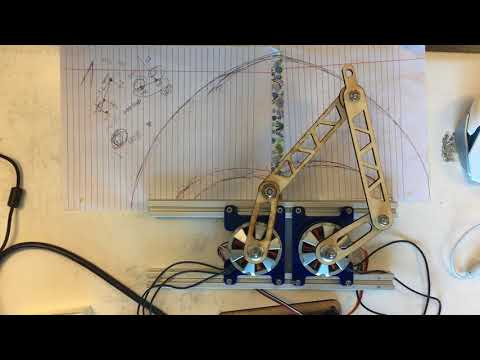

In [42]:
#
#  Youtube video for gait 2
#
YouTubeVideo('ZsLjyjOLglM')

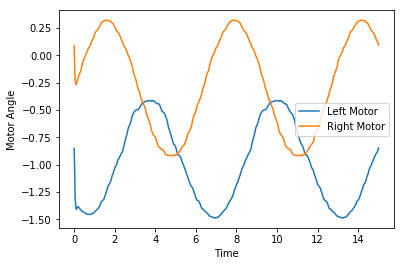

In [39]:
#
#  Plot for gait 3
#Amplitude_left =-400 
#Amplitude_right =500 
#Phase_left = 2*math.pi/3
#Phase_right = math.pi
calibration=-4096/math.pi
plt.plot(t, np.divide(left_motor,calibration),t, np.divide(right_motor,calibration))
#RM=plt.plot(t, np.divide(right_motor,calibration))
plt.xlabel('Time')
plt.ylabel('Motor Angle')
plt.gca().legend(('Left Motor','Right Motor'))

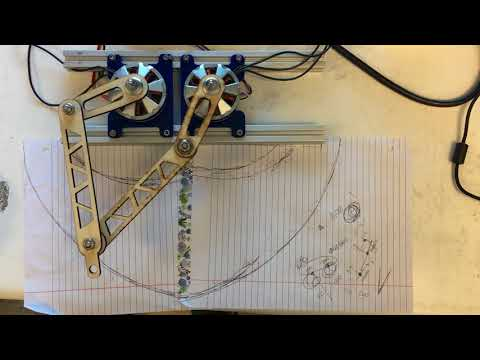

In [43]:
#
#  Youtube video for gait 3
#
YouTubeVideo('QdEief40gtM')